In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D,ZeroPadding2D
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math

from keras.applications import VGG16, vgg16
from keras import backend as K
import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
base_image_path = "GoghSelfDoodle.jpg"
style_reference_image_path = "GoghSelf.jpg"

total_variation_weight = 1.0
style_weight = 1.0*100
content_weight = 0.025 

width, height = load_img(base_image_path).size
img_nrows = 224
img_ncols = 224#int(width * img_nrows / height)

IOError: [Errno 2] No such file or directory: 'GoghSelfDoodle.jpg'

In [88]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img) * 1.0
    img = np.expand_dims(img, axis=0)
#     img = vgg16.preprocess_input(img) 
    return img


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, 3, img_nrows, img_ncols))

In [89]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (0, 1, 2)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    sLoss = K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
#     print sLoss.eval()
    return sLoss

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
    b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    return K.sum(K.pow(a + b, 1.25))

In [90]:
def get_loss2(y_true, y_pred):
    sty = (style_reference_image)/256.0
    combo =  y_pred#vgg16.preprocess_input (y_pred * 256)
    base = (base_image)/256.0

    input_tensor = K.concatenate([base, sty, combo], axis=0)

    model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    print('Model loaded.')

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    loss = K.variable(0.)
    layer_features = outputs_dict['block4_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = content_weight * content_loss(base_image_features, combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']
    
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
   
    loss += total_variation_weight * total_variation_loss(combo)
    return loss 

In [106]:
def get_loss_doodle(y_true, y_pred):
    sty = (style_reference_image)/256.0
    combo =  y_pred#vgg16.preprocess_input (y_pred * 256)
    base = (base_image)/256.0

    input_tensor = K.concatenate([base, sty, combo], axis=0)

    model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    print('Model loaded.')

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    loss = K.variable(0.)
    layer_features = outputs_dict['block4_conv2']
    base_image_features = layer_features[0, :, :, :]
    sty_image_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = content_weight * content_loss(sty_image_features, combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']
    
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
   
    loss += total_variation_weight * total_variation_loss(combo)
    return loss 

In [107]:
# Combine generative layer with VGG layer
inputs = Input(shape=( 224*224*3, ))

# Layer 1
x1 = Dense(5, activation = 'tanh', init = 'glorot_uniform')(inputs)

# Layer 2
x = Dense(64*56*56, activation = 'tanh', init = 'glorot_uniform')(x1)
x = BatchNormalization()(x)
x = Reshape((64, 56, 56))(x)

# Layer 3
x = UpSampling2D(size = (2, 2))(x) 
x = Convolution2D(16, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 4
# x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 5
# x = UpSampling2D(size = (4, 4))(x) #shape is (16, 112, 112)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) 
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)


#  output shape is (None, 3, 224, 224)
generative_model = Model(input = inputs, output = out)

In [108]:
# Combine generative layer with VGG layer
inputs = Input(shape=( 3, 224,224, ))

# Layer 1
# x1 = Dense(5, activation = 'tanh', init = 'glorot_uniform')(inputs)

# # Layer 2
# x = Dense(64*56*56, activation = 'tanh', init = 'glorot_uniform')(x1)
# x = BatchNormalization()(x)
# x = Reshape((64, 56, 56))(x)
x = ZeroPadding2D((1,1))(inputs)
x = Convolution2D(16, 5, 5, border_mode = 'same', activation = 'relu')(x)
x = ZeroPadding2D((1,1))(x)
x = Convolution2D(64, 3, 3, activation='relu')(x)
x = MaxPooling2D((2,2), strides=(2,2))(x)
x = ZeroPadding2D((1,1))(x)
x = Convolution2D(128, 3, 3, activation='relu')(x)
x = MaxPooling2D((2,2), strides=(2,2))(x)
x = ZeroPadding2D((1,1))(x)
x = Convolution2D(128, 3, 3, activation='relu')(x)
# x = MaxPooling2D((2,2), strides=(2,2))
# x = BatchNormalization()(x)
# x = Reshape((64, 56, 56))(x)


#     model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
#     model.add(Convolution2D(64, 3, 3, activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(64, 3, 3, activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(128, 3, 3, activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Convolution2D(128, 3, 3, activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

# Layer 3
x = UpSampling2D(size = (2, 2))(x) 
x = Convolution2D(16, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 4
# x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 5
# x = UpSampling2D(size = (4, 4))(x) #shape is (16, 112, 112)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) 
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)


#  output shape is (None, 3, 224, 224)
generative_model2 = Model(input = inputs, output = out)

In [109]:
generative_model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_40 (InputLayer)            (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
zeropadding2d_21 (ZeroPadding2D) (None, 3, 226, 226)   0           input_40[0][0]                   
____________________________________________________________________________________________________
convolution2d_78 (Convolution2D) (None, 16, 226, 226)  1216        zeropadding2d_21[0][0]           
____________________________________________________________________________________________________
zeropadding2d_22 (ZeroPadding2D) (None, 16, 228, 228)  0           convolution2d_78[0][0]           
___________________________________________________________________________________________

In [110]:
jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
inp = np.reshape(inp, (3, -1))
inpY = 1.0 * np.reshape(inp, (1, 3, 224, 224)) 


# jpgfile = Image.open("ucsd.jpg")
# inp = np.array(jpgfile.getdata())
inp = base_image.eval()
trainX = np.reshape(inp, (1, 3, 224, 224)) / 256.0
trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
trainX3 = trainX2
print np.product(trainX.shape)
trainX3 = np.random.rand(1, 150528)

inpY = inpY/256.0

150528


In [111]:
adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
generative_model.compile(loss = get_loss2, optimizer = adam_op)

Model loaded.


In [112]:
adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
generative_model2.compile(loss = get_loss_doodle, optimizer = adam_op)

Model loaded.


Epoch 1/10
1/1 [==============================] - 5s - loss: 234820.9688
Epoch 2/10
1/1 [==============================] - 5s - loss: 231133.7969
Epoch 3/10
1/1 [==============================] - 4s - loss: 221140.8281
Epoch 4/10
1/1 [==============================] - 4s - loss: 218333.1094
Epoch 5/10
1/1 [==============================] - 4s - loss: 216622.0156
Epoch 6/10
1/1 [==============================] - 4s - loss: 213956.1406
Epoch 7/10
1/1 [==============================] - 5s - loss: 212984.9219
Epoch 8/10
1/1 [==============================] - 7s - loss: 209488.2656
Epoch 9/10
1/1 [==============================] - 5s - loss: 207642.9531
Epoch 10/10
1/1 [==============================] - 6s - loss: 205266.0938
(3, 224, 224)


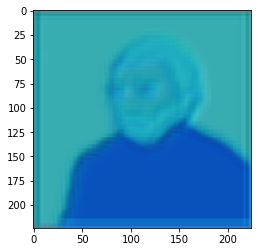

Epoch 1/10
1/1 [==============================] - 6s - loss: 202980.9844
Epoch 2/10
1/1 [==============================] - 5s - loss: 202336.3594
Epoch 3/10
1/1 [==============================] - 5s - loss: 200354.9844
Epoch 4/10
1/1 [==============================] - 4s - loss: 197285.7188
Epoch 5/10
1/1 [==============================] - 4s - loss: 193722.8281
Epoch 6/10
1/1 [==============================] - 4s - loss: 191298.3281
Epoch 7/10
1/1 [==============================] - 4s - loss: 186949.2344
Epoch 8/10
1/1 [==============================] - 4s - loss: 184670.0625
Epoch 9/10
1/1 [==============================] - 4s - loss: 183031.9844
Epoch 10/10
1/1 [==============================] - 4s - loss: 180391.5000
(3, 224, 224)


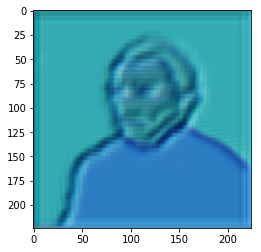

Epoch 1/10
1/1 [==============================] - 4s - loss: 178625.9531
Epoch 2/10
1/1 [==============================] - 4s - loss: 177462.2344
Epoch 3/10
1/1 [==============================] - 5s - loss: 176013.1719
Epoch 4/10
1/1 [==============================] - 4s - loss: 174329.4375
Epoch 5/10
1/1 [==============================] - 4s - loss: 173108.8750
Epoch 6/10
1/1 [==============================] - 4s - loss: 171477.5938
Epoch 7/10
1/1 [==============================] - 4s - loss: 169838.4375
Epoch 8/10
1/1 [==============================] - 4s - loss: 168645.2344
Epoch 9/10
1/1 [==============================] - 4s - loss: 167749.0156
Epoch 10/10
1/1 [==============================] - 4s - loss: 166958.6875
(3, 224, 224)


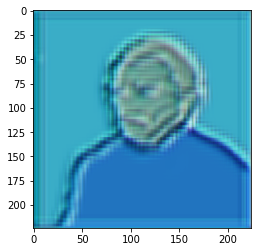

Epoch 1/10
1/1 [==============================] - 4s - loss: 166414.4062
Epoch 2/10
1/1 [==============================] - 4s - loss: 165997.5156
Epoch 3/10
1/1 [==============================] - 4s - loss: 165792.2969
Epoch 4/10
1/1 [==============================] - 4s - loss: 165731.2188
Epoch 5/10
1/1 [==============================] - 4s - loss: 164766.2188
Epoch 6/10
1/1 [==============================] - 4s - loss: 164502.3281
Epoch 7/10
1/1 [==============================] - 4s - loss: 164794.1250
Epoch 8/10
1/1 [==============================] - 4s - loss: 164322.2656
Epoch 9/10
1/1 [==============================] - 4s - loss: 166503.9688
Epoch 10/10
1/1 [==============================] - 4s - loss: 166515.1250
(3, 224, 224)


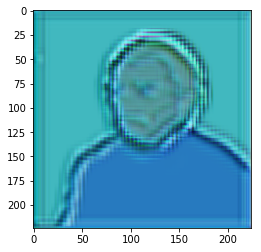

Epoch 1/10
1/1 [==============================] - 4s - loss: 166003.4844
Epoch 2/10
1/1 [==============================] - 4s - loss: 166547.3281
Epoch 3/10
1/1 [==============================] - 4s - loss: 167013.1406
Epoch 4/10
1/1 [==============================] - 4s - loss: 166552.8594
Epoch 5/10
1/1 [==============================] - 4s - loss: 164979.0312
Epoch 6/10
1/1 [==============================] - 4s - loss: 165608.0781
Epoch 7/10
1/1 [==============================] - 4s - loss: 166697.4531
Epoch 8/10
1/1 [==============================] - 4s - loss: 171098.7812
Epoch 9/10
1/1 [==============================] - 4s - loss: 171652.1406
Epoch 10/10
1/1 [==============================] - 4s - loss: 172143.2344
(3, 224, 224)


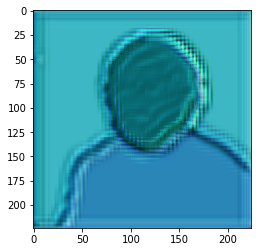

Epoch 1/10
1/1 [==============================] - 4s - loss: 170019.6719
Epoch 2/10
1/1 [==============================] - 5s - loss: 172657.2812
Epoch 3/10
1/1 [==============================] - 4s - loss: 172185.1875
Epoch 4/10
1/1 [==============================] - 4s - loss: 173816.0938
Epoch 5/10
1/1 [==============================] - 4s - loss: 173602.4062
Epoch 6/10
1/1 [==============================] - 4s - loss: 169427.4844
Epoch 7/10
1/1 [==============================] - 4s - loss: 173406.4062
Epoch 8/10
1/1 [==============================] - 4s - loss: 173169.8438
Epoch 9/10
1/1 [==============================] - 4s - loss: 171608.5781
Epoch 10/10
1/1 [==============================] - 4s - loss: 165797.8281
(3, 224, 224)


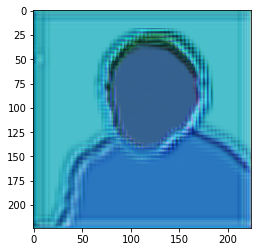

Epoch 1/10
1/1 [==============================] - 4s - loss: 172457.3750
Epoch 2/10
1/1 [==============================] - 4s - loss: 171468.8281
Epoch 3/10
1/1 [==============================] - 4s - loss: 171192.8750
Epoch 4/10
1/1 [==============================] - 4s - loss: 170755.7812
Epoch 5/10
1/1 [==============================] - 4s - loss: 166988.9219
Epoch 6/10
1/1 [==============================] - 4s - loss: 172811.3594
Epoch 7/10
1/1 [==============================] - 4s - loss: 173221.3438
Epoch 8/10
1/1 [==============================] - 4s - loss: 172769.5938
Epoch 9/10
1/1 [==============================] - 4s - loss: 174033.3125
Epoch 10/10
1/1 [==============================] - 4s - loss: 172062.2969
(3, 224, 224)


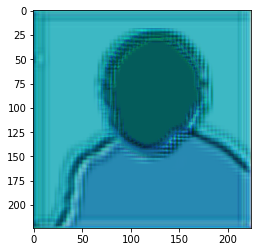

Epoch 1/10
1/1 [==============================] - 4s - loss: 176319.6094
Epoch 2/10
1/1 [==============================] - 4s - loss: 176060.7969
Epoch 3/10
1/1 [==============================] - 4s - loss: 175002.7344
Epoch 4/10
1/1 [==============================] - 4s - loss: 175223.6719
Epoch 5/10
1/1 [==============================] - 4s - loss: 175078.3594
Epoch 6/10
1/1 [==============================] - 4s - loss: 174285.5000
Epoch 7/10
1/1 [==============================] - 4s - loss: 171728.9531
Epoch 8/10
1/1 [==============================] - 4s - loss: 171260.5312
Epoch 9/10
1/1 [==============================] - 4s - loss: 171406.3594
Epoch 10/10
1/1 [==============================] - 4s - loss: 171159.8438
(3, 224, 224)


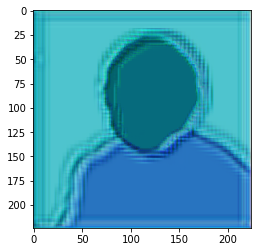

Epoch 1/10
1/1 [==============================] - 4s - loss: 170580.6562
Epoch 2/10
1/1 [==============================] - 4s - loss: 169899.4688
Epoch 3/10
1/1 [==============================] - 4s - loss: 167912.7344
Epoch 4/10
1/1 [==============================] - 4s - loss: 169349.8125
Epoch 5/10
1/1 [==============================] - 4s - loss: 169402.6406
Epoch 6/10
1/1 [==============================] - 4s - loss: 168646.0938
Epoch 7/10
1/1 [==============================] - 5s - loss: 169046.9375
Epoch 8/10
1/1 [==============================] - 4s - loss: 167734.2344
Epoch 9/10
1/1 [==============================] - 4s - loss: 168055.8281
Epoch 10/10
1/1 [==============================] - 4s - loss: 168273.3281
(3, 224, 224)


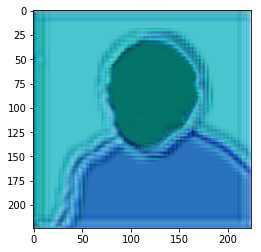

Epoch 1/10
1/1 [==============================] - 4s - loss: 168039.3281
Epoch 2/10
1/1 [==============================] - 4s - loss: 164218.4688
Epoch 3/10
1/1 [==============================] - 4s - loss: 168993.2656
Epoch 4/10
1/1 [==============================] - 4s - loss: 169712.7344
Epoch 5/10
1/1 [==============================] - 4s - loss: 169320.1875
Epoch 6/10
1/1 [==============================] - 4s - loss: 167548.3750
Epoch 7/10
1/1 [==============================] - 4s - loss: 168460.8750
Epoch 8/10
1/1 [==============================] - 4s - loss: 164590.5625
Epoch 9/10
1/1 [==============================] - 4s - loss: 166730.0156
Epoch 10/10
1/1 [==============================] - 4s - loss: 165637.9062
(3, 224, 224)


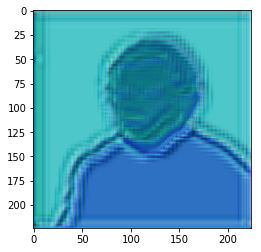

In [113]:
for i in range(10):
    generative_model2.fit(trainX, inpY, nb_epoch = 10)
    img = generative_model2.predict(trainX)
    img = img[0]
    print img.shape
    img = img.swapaxes(0, 2).swapaxes(0, 1)
    plt.imshow(img)
    plt.show()

In [74]:
# img = generative_model2.predict(trainX)
# img = img[0]
# print img.shape
# img = img.swapaxes(0, 2).swapaxes(0, 1)
# plt.imshow(img)
# plt.show()

In [58]:
# print img

(3, 224, 224)


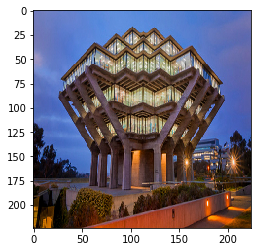

In [61]:
# # generative_model.fit(trainX3, inpY, nb_epoch = 10)
# img = generative_model.predict(trainX3)
# img = img[0]
# print img.shape
# img = img.swapaxes(0, 2).swapaxes(0, 1)
# plt.imshow(img)
# plt.savefig('styletsfr.jpg')
# # plt.show()